# FIND BELOW THE (RECURRENT) RANDOM FOREST ANALYSIS

# Install Packages

In [1]:
# !pip install jupyter_contrib_nbextensions
# !jupyter contrib nbextension install --user
# !jupyter nbextension enable collapsible_headings/main
# !pip install astropy
# !pip install seaborn
# !pip install site

# Import Packages

In [1]:
#astrology packages
from astropy.table import Table
import astropy.coordinates as coord
import glob
from astropy import units as u
from astroquery.gaia import Gaia

#data processing
import pandas as pd
import numpy as np
import math as math
from tqdm import tqdm
import collections
import copy

#visualizations
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.use('Agg')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
#import plotly.graph_objects as go
#import seaborn as sns

#models
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import RandomizedSearchCV

#data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef


#for my sanity
import warnings
warnings.filterwarnings('ignore')

/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


We now have all the stream files:

# Define Relevant Non-Model Functions

In [15]:
def obtain_noise(min_ra, max_ra, min_dec, max_dec, max_rel_err, n_points):
    
    qry = f" \n\
    select top {n_points} source_id, \n\
    dr2.ra, \n\
    dr2.dec, \n\
    parallax, \n\
    parallax_error, \n\
    pmra, \n\
    pmdec, \n\
    phot_g_mean_mag,\n\
    phot_bp_mean_mag, \n\
    phot_rp_mean_mag, \n\
    bp_rp, \n\
    bp_g, \n\
    g_rp\n\
    from gaiadr2.gaia_source as dr2 \n\
    where dr2.ra > {min_ra} and dr2.ra < {max_ra} and dr2.dec > {min_dec} and dr2.dec < {max_dec} \n\
    and parallax is not null \n\
    and parallax_error is not null \n\
    and abs(dr2.parallax/dr2.parallax_error) < {max_rel_err} \n\
    and pmra is not null \n\
    and pmdec is not null \n\
    and phot_g_mean_mag is not null \n\
    and phot_bp_mean_mag is not null \n\
    and phot_rp_mean_mag is not null \n\
    and bp_rp is not null \n\
    and bp_g is not null \n\
    and g_rp is not null \n\
    order by random_index"

    data_noise = Gaia.launch_job_async(qry).get_results().to_pandas()
    
    return data_noise

#For each mock stream, we wish to obtain a fixed test set that represents the realistic ratio of non-stream stars to stream stars
def obtain_test_set(list_of_stellar_streams, multiple):

    for i in list_of_stellar_streams:
        table = Table.read(i, format='fits')
        stream = table.to_pandas()
        
        idx = cuts.index[cuts.stream_file==str(i)][0]

        ra_min = cuts.loc[idx].ra_min
        ra_max = cuts.loc[idx].ra_max
        dec_min = cuts.loc[idx].dec_min
        dec_max = cuts.loc[idx].dec_max
        
        #restrict stream to relevant portion
        stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

        #obtain noise points such that:
        #- the ratio of stream to noise points in the test set is 1:multiple
        #- this is required because KNN introduces bias when the ratios are imbalanced
        n_points = len(stream) * multiple
        #use max_rel_err of 0.5
        max_rel_err =  0.5

        #we now select our noise points that we will incorporate into our training and test set
        noise_points = obtain_noise(ra_min, ra_max, dec_min, dec_max, max_rel_err, n_points)

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False
        
        #send to csv
        name = i[18:-8]+'_mul_400_total_noise.csv'
        noise_points.to_csv(name)

    return noise_points

# Define Relevant Model Functions

In [23]:
#let us define a function to run logistic regression on our data set and evaluate the results
def log_reg_model(X_train, X_test, y_train, y_test, threshold_log):
    #do the logistic regression modeling
    log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='ovr').fit(X_train, y_train)
    
    THRESHOLD = threshold_log
    y_pred = np.where(log_reg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
    
    y_pred = log_reg.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

#defaults for hyperparameters are set to match those used in sklearn
def random_forest_model(X_train, X_test, y_train, y_test, n_trees = 100, criterion = "gini", max_depth = None,
                       min_samples_split = 2, min_samples_leaf = 1, min_weight_fraction_leaf = 0, max_features = "auto", 
                        max_leaf_nodes = None, min_impurity_split = 1e-7, bootstrap = True,
                        oob_score = False, n_jobs = None, random_state = None, verbose = 0, warm_start = False, class_weight = {0:1,1:1}):
    #do the random forest modeling
    random_forest = RandomForestClassifier(
                                            n_estimators = n_trees, criterion = criterion, 
                                            max_depth = max_depth, min_samples_split = min_samples_split, 
                                            min_samples_leaf = min_samples_leaf, 
                                            min_weight_fraction_leaf = min_weight_fraction_leaf, 
                                            max_features = max_features, max_leaf_nodes = max_leaf_nodes,  
                                            min_impurity_split = min_impurity_split, bootstrap = bootstrap, 
                                            oob_score = oob_score, n_jobs = n_jobs, 
                                            random_state = random_state, verbose = verbose, warm_start = False,
                                            class_weight = {0:weight_0,1:weight_1}
                                          ).fit(X_train, y_train)
    
    y_pred = random_forest.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true, random_forest

#defaults for hyperparameters are set to match those used in sklearn
def gradient_boost_model(X_train, X_test, y_train, y_test, loss = 'deviance', learning_rate = 0.1, n_estimators = 100, 
                         subsample = 1.0, criterion = "friedman_mse", min_samples_split = 2, 
                         min_samples_leaf = 1, min_weight_fraction_leaf = 0., max_depth = 3, 
                         min_impurity_decrease = 0, min_impurity_split = 1e-7, init = None,
                         random_state = None, max_features = None, max_leaf_nodes = None, verbose = 0,
                         warm_start  = False): #validation_fraction = 0.1, 
                         #n_iter_no_change = None, tol = 1e-4, ccp_alpha = 0.0):
    #do the gradient boosting modeling
    gradient_boost = GradientBoostingClassifier(
                                                loss = loss, learning_rate = learning_rate, 
                                                n_estimators = n_estimators, 
                                                subsample = subsample, criterion = criterion, 
                                                min_samples_split = min_samples_split, 
                                                min_samples_leaf = min_samples_leaf, 
                                                min_weight_fraction_leaf = min_weight_fraction_leaf, 
                                                max_depth = max_depth, 
                                                min_impurity_decrease = min_impurity_decrease, 
                                                min_impurity_split = min_impurity_split, init = init,
                                                random_state = random_state, max_features = max_features, 
                                                max_leaf_nodes = max_leaf_nodes, verbose = verbose,
                                                warm_start = warm_start #validation_fraction = validation_fraction, 
                                                #n_iter_no_change = n_iter_no_change, tol = tol, ccp_alpha = ccp_alpha
                                              ).fit(X_train, y_train)
    
    y_pred = gradient_boost.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

#defaults for hyperparameters are set to match those used in sklearn
def one_class_svm_model(X_train, X_test, y_train, y_test, 
                        kernel = 'rbf', degree = 3, gamma = 0.001, 
                        coef0 = 0.0, tol = 0.001, nu = 0.5, shrinking = True, 
                        cache_size = 200, verbose = False, max_iter = -1, random_state = None):
    #do the random forest modeling
    one_class_svm = OneClassSVM(
                                kernel = kernel, degree = degree, gamma = gamma, coef0 = coef0, 
                                tol = tol, nu = nu, shrinking = shrinking, cache_size = cache_size, 
                                verbose = verbose, max_iter = max_iter, random_state = random_state
                               ).fit(X_train, y_train)
    
    y_pred = one_class_svm.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred, average='micro')
    recall = metrics.recall_score(y_true, y_pred, average='micro')
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

def knn_model(X_train, X_test, y_train, y_test, k):
    #do the KNN modeling
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

# Introduce and Load our Data Set

In [2]:
filename = "data/gd1_in_gaia.h5"
dataset = pd.read_hdf(filename, 'df')

In [36]:
#separate the data points that belong to GD1
dataset_gd1 = dataset[dataset['pm_mask'] == True]
dataset_gd1 = dataset_gd1[dataset_gd1['gi_cmd_mask'] == True]
dataset_gd1 = dataset_gd1[dataset_gd1['stream_track_mask'] == True]
dataset_gd1['in_gd1'] = 1

#separate the data points that do not belong to GD1 AND have passed through the isochrone filter
dataset_nongd = dataset[(dataset['pm_mask']== False) | (dataset['stream_track_mask'] == False)]
dataset_nongd = dataset_nongd[dataset_nongd['gi_cmd_mask'] == True]
dataset_nongd['in_gd1'] = 0

In [39]:
#stars known to model
stream_train_gd1 = pd.read_csv('stream_stars_split/gd1/gd1_stellar_stream_known_to_model.csv', index_col = 0)

#unknown to model
stream_test_gd1 = pd.read_csv('stream_stars_split/gd1/gd1_stellar_stream_unknown_to_model.csv', index_col = 0)

In [41]:
multiple_test = 150
multiple_train = 400
#we want a ratio of 150:1 for each value in the test set where the test is 90% of our data set
len_noise_test = len(stream_test_gd1) * multiple_test
gd1_noise_test = dataset_nongd.sample(n=len_noise_test,random_state=1)
indices_test = list(gd1_noise_test.index)
gd1_noise_train_pool = dataset_nongd[~dataset_nongd.index.isin(indices_test)]
#we want a ratio of 400:1 for each value in the training set where the training set is 10% of our data set.
len_noise_train = len(stream_train_gd1) * multiple_train
gd1_noise_train = gd1_noise_train_pool.sample(n=len_noise_train,random_state=1)

# Test Random Forest Model

## Define Function for Recursive Portion

In [47]:
def rf_recursion_gd1 (training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf, plot_permit, X_correct_cum, X2_incorrect_cum):

    true_positives = []
    false_positives = []
    true_negatives = []
    false_negatives = []
    y_preds = []
    testing_datas = []
    training_datas = []
    multiple = 150

    weight_1_options = [1]
    precisions = []
    recalls = []
    f1s_weights = []

    training_streams_2 = []
    testing_streams_2 = []
    correct_X_2 = []
    incorrect_X2_2 = []
    self_labs_2 = []

    stream_train_prev = training_streams[0]
    stream_test_prev = testing_streams[0]
    X_correct_prev = correct_X[0]
    X2_incorrect_prev = incorrect_X2[0]


#     stellar_stream = pd.read_csv('stream_stars_split/group_c_intelligent/'+stream_name+ '_intelligent_cut.csv')
#     stellar_stream_valid_b = stellar_stream[stellar_stream['meets_b_req']==True]
#     #stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
#     #stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"

    #stars known to model
    stream_train2 = stream_train_prev.append(stream_test_prev[stream_test_prev.index.isin(X_correct_prev.index)], ignore_index = False, sort = True)
    stream_train2 = stream_train2.append(stream_test_prev[stream_test_prev.index.isin(X2_incorrect_prev.index)], ignore_index = False, sort = True)
    stream_train2['stream_mask'] = True

    #unknown to model
    stream_test2 = stream_test_prev[~stream_test_prev.index.isin(X_correct_prev.index)]
    stream_test2['stream_mask'] = True  

#     #obtain noise points such that:
#     #- the ratio of stream to noise points in the training set is 1:multiple
#     #- the ratio of stream to noise points in the test set is close to the 'real' ratio
#     test_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
#     name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

#     train_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
#     name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

#     noise_test = pd.read_csv(name_test, index_col = 0)
#     noise_points = pd.read_csv(name_train, index_col = 0)

#     #add back the test points into the muck and assume they're background stars from which to draw
#     noise_points = noise_points.append(stream_test2, ignore_index = False, sort = True)
#     train_points = len(stream_train2) * multiple

#     #label our data as "not part of the stream"
#     noise_points['stream_mask'] = False

#     msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
#     noise_train = noise_points[msk2]
#     #noise_test = noise_points[~msk2]
    
    noise_train = gd1_noise_train
    noise_train['stream_mask'] = False
    noise_test = gd1_noise_test
    noise_test['stream_mask'] = False
    
    #add back the test points into the muck and assume they're background stars from which to draw
    noise_train = noise_train.append(stream_test2, ignore_index = False, sort = True)

    #re-label our data as "not part of the stream"
    noise_train['stream_mask'] = False

    #combine my stream and noise to obtain complete training and test data set
    training_data = stream_train2.append(noise_train, ignore_index = False, sort = True)
    training_data = training_data[['ra', 'dec', 'pmra_x', 'pmdec_x', 'g', 'g_bp', 'g_rp', 'stream_mask']]

    testing_data = stream_test2.append(noise_test, ignore_index = False, sort = True)
    testing_data = testing_data[['ra', 'dec', 'pmra_x', 'pmdec_x',  'g', 'g_bp', 'g_rp', 'stream_mask']]
    
    #there is only stream
    testing_data = self_labs[0]
    testing_data = testing_data[~testing_data.index.isin(X_correct_prev.index)] #TP
    testing_data = testing_data[~testing_data.index.isin(X2_incorrect_prev.index)] #FP

    #Convert to Angular Coordinates
    #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
    #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
    #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

    deg2rad = lambda deg: deg/180.*np.pi

    #Convert data to angular velocities
    training_data['ra_rad'] = deg2rad(training_data['ra'])
    training_data['dec_rad'] = deg2rad(training_data['dec'])

    training_data['ang_coord_1'] = -1 * training_data.pmdec_x * ( np.cos(training_data.ra_rad)) -  training_data.pmdec_x * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
    training_data['ang_coord_2'] = -1 * training_data.pmra_x *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra_x * np.sin(training_data.ra_rad))
    training_data['ang_coord_3'] = training_data.pmra_x * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )


    testing_data['ra_rad'] = deg2rad(testing_data['ra'])
    testing_data['dec_rad'] = deg2rad(testing_data['dec'])

    testing_data['ang_coord_1'] = -1 * testing_data.pmdec_x * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec_x * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
    testing_data['ang_coord_2'] = -1 * testing_data.pmra_x *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra_x * np.sin(testing_data.ra_rad))
    testing_data['ang_coord_3'] = testing_data.pmra_x * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )

    self_labs_2.append(testing_data)


    #differentiate training and test data's X and y variables
    #X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
    #y_train = training_data.stream_mask

    #X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
    #y_test = testing_data.stream_mask


    #differentiate training and test data's X and y variables
    #X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    X_train = training_data[['ra', 'dec', 'pmra_x', 'pmdec_x', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'g', 'g_bp', 'g_rp']]
    y_train = training_data.stream_mask

    #X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    X_test = testing_data[['ra', 'dec', 'pmra_x', 'pmdec_x','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'g', 'g_bp', 'g_rp']]
    y_test = testing_data.stream_mask


    #scale the features using standard scaler (scaling not required for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit(X_train).transform(X_train)
    X_test_scaled = scaler.fit(X_train).transform(X_test)


    #use mean square sum for angular velocity (wx/N, wy/N, wz/N), where N = sqrt(wx^2 + wy^2 + wz^2)
#     X_train_scaled = pd.DataFrame(X_train_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])
#     X_test_scaled = pd.DataFrame(X_test_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']) 

#     X_train_scaled['mean_square_sum'] = X_train_scaled['ang_coord_1']**2+X_train_scaled['ang_coord_2']**2+X_train_scaled['ang_coord_3']**2
#     X_train_scaled['ang_coord_1'] = X_train_scaled['ang_coord_1'] / X_train_scaled['mean_square_sum']
#     X_train_scaled['ang_coord_2'] = X_train_scaled['ang_coord_2'] / X_train_scaled['mean_square_sum']
#     X_train_scaled['ang_coord_3'] = X_train_scaled['ang_coord_3'] / X_train_scaled['mean_square_sum']
#     X_train_scaled = X_train_scaled.drop(['mean_square_sum'], axis = 1)
#     X_train_scaled = np.array(X_train_scaled)

#     X_test_scaled['mean_square_sum'] = X_test_scaled['ang_coord_1']**2+X_test_scaled['ang_coord_2']**2+X_test_scaled['ang_coord_3']**2
#     X_test_scaled['ang_coord_1'] = X_test_scaled['ang_coord_1'] / X_test_scaled['mean_square_sum']
#     X_test_scaled['ang_coord_2'] = X_test_scaled['ang_coord_2'] / X_test_scaled['mean_square_sum']
#     X_test_scaled['ang_coord_3'] = X_test_scaled['ang_coord_3'] / X_test_scaled['mean_square_sum']
#     X_test_scaled = X_test_scaled.drop(['mean_square_sum'], axis = 1)
#     X_test_scaled = np.array(X_test_scaled)    

    precision, recall, accuracy, auc, y_pred, y_true, forest = random_forest_model(X_train_scaled, X_test_scaled, y_train, y_test, 
                                                                           n_trees = n_estimator_opt, criterion = "gini", max_depth = depth_opt,
                                                                           min_samples_split = min_split_opt, min_samples_leaf = min_leaf_opt, 
                                                                           min_weight_fraction_leaf = 0, max_features = max_feature_opt, 
                                                                           max_leaf_nodes = None, min_impurity_decrease = 0, 
                                                                           min_impurity_split = 1e-7, bootstrap = bootstrap_opt,
                                                                           oob_score = False, n_jobs = 1, 
                                                                           random_state = None, verbose = 0, warm_start = False, class_weight = {0:weight_0,1:weight_1})


    #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
    #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
    #Truly in Cluster
    X_correct = testing_data[y_test & y_pred] #predicted in cluster (true positives)
    X_incorrect = testing_data[y_test & ~y_pred] #predicted not in cluster (false negative)
    #Truly not in Cluster
    X2_correct = testing_data[~y_test & ~y_pred] #predicted not in cluster (true negative)
    X2_incorrect = testing_data[~y_test & y_pred] #predicted in cluster (false positive)

    X_correct_cum = X_correct_cum.append(X_correct, ignore_index = False, sort = True) #true positives
    #X_incorrect_cum.append(X_incorrect, ignore_index = False, sort = True)
    #X2_correct_cum.append(X2_correct, ignore_index = False, sort = True)
    X2_incorrect_cum = X2_incorrect_cum.append(X2_incorrect, ignore_index = False, sort = True) #false positives

    if plot_permit == 'yes':
        X_correct_cum['species']='TP'
        X_incorrect_cum['species']='FN'
        X2_incorrect['species']='FP'

        sns_frame = X_correct_cum.append(X_incorrect_cum, ignore_index = False, sort = True)
        sns_frame = sns_frame.append(X2_incorrect, ignore_index = False, sort = True)

        sns_frame = sns_frame[['ra','dec','pmra_x','pmdec_x', 'g', 'g_bp', 'g_rp', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'species']]

        g = sns.pairplot(sns_frame, hue = 'species', hue_order = ['TP', 'FN', 'FP'])
        g.fig.suptitle('Pairwise Plot for GD1', y = 1.08)

    true_positives.append(len(X_correct))
    false_positives.append(len(X2_incorrect))
    true_negatives.append(len(X2_correct))
    false_negatives.append(len(X_incorrect))
    y_preds.append(y_pred)
    testing_datas.append(testing_data)
    training_datas.append(training_data)
    training_streams_2.append(stream_train2)
    testing_streams_2.append(stream_test2)
    correct_X_2.append(X_correct)
    incorrect_X2_2.append(X2_incorrect)

    final_result_rf2 = pd.DataFrame()
    final_result_rf2['true_positives']=true_positives+recursive_frames[(len(recursive_frames)-1)].true_positives
    final_result_rf2['false_positives']=false_positives+recursive_frames[(len(recursive_frames)-1)].false_positives
    final_result_rf2['true_negatives']=true_negatives
    final_result_rf2['false_negatives']=false_negatives
    #final_result['auc'] = aucs
    final_result_rf2['precision'] = final_result_rf2.true_positives / (final_result_rf2.true_positives + final_result_rf2.false_positives)
    final_result_rf2['recall'] = final_result_rf2.true_positives / (final_result_rf2.true_positives + final_result_rf2.false_negatives)
    final_result_rf2['f1'] = 2*(final_result_rf2.precision * final_result_rf2.recall)/(final_result_rf2.precision + final_result_rf2.recall)
#     beta = 0.1
#     final_result_rf2['f1_prec_10'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    beta = 0.5
    final_result_rf2['f0.5'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    beta = 2
    final_result_rf2['f2'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    final_result_rf2['bal_acc']= (final_result_rf2.true_positives/(final_result_rf2.true_positives + final_result_rf2.false_negatives)+ final_result_rf2.true_negatives/(final_result_rf2.true_negatives+final_result_rf2.false_positives))/2
    final_result_rf2['matt_coef'] = (final_result_rf2.true_positives * final_result_rf2.true_negatives - final_result_rf2.false_positives * final_result_rf2.false_negatives)/((final_result_rf2.true_positives + final_result_rf2.false_positives)*(final_result_rf2.true_positives + final_result_rf2.false_negatives)*(final_result_rf2.true_negatives + final_result_rf2.false_positives)*(final_result_rf2.true_negatives + final_result_rf2.false_negatives))**0.5

    #     precisions.append(final_result_rf.mean().precision)
    #     recalls.append(final_result_rf.mean().recall)
    #     f1s_weights.append(final_result_rf.mean().f1)

    #     recursive_frames.append(final_result_rf2)

    return training_streams_2, testing_streams_2, correct_X_2, incorrect_X2_2, self_labs_2, final_result_rf2, X_correct_cum, X2_incorrect_cum, forest

## Run Recursive Random Forest

In [48]:
# #define optimal parameters
# n_estimator_opt = params_opt[0]
# max_feature_opt = params_opt[1]
# depth_opt = params_opt[2]
# min_split_opt = params_opt[3]
# min_leaf_opt = params_opt[4]
# bootstrap_opt = params_opt[5]
iteration_1 = []
iteration_final = []

#weight_1_ops = [1,5,10,25,50,100,150,250,400,500] #all options
weight_1_ops = [50]

for weight_1_option in weight_1_ops:
    n_estimator_opt = 200
    max_feature_opt = 'auto'
    depth_opt = 10
    min_split_opt = 2
    min_leaf_opt = 1
    bootstrap_opt = True
    weight_0 = 1
    weight_1 = weight_1_option #high precision model has this = 1; alternatively, balanced model has this = 500

    recursive_frames = []

    stream_name_rf = []
    true_positives = []
    false_positives = []
    true_negatives = []
    false_negatives = []
    y_preds = []
    testing_datas = []
    training_datas = []
    multiple = 150
    self_labs = []

    precisions = []
    recalls = []
    f1s_weights = []

    training_streams = []
    testing_streams = []
    correct_X = []
    incorrect_X2 = []

    #stars known to model
    stream_train = stream_train_gd1
    stream_train['stream_mask'] = True
    
    #unknown to model
    stream_test = stream_test_gd1
    stream_test['stream_mask'] = True
    
    noise_train = gd1_noise_train
    noise_train['stream_mask'] = False
    noise_test = gd1_noise_test
    noise_test['stream_mask'] = False
    
    #add back the test points into the muck and assume they're background stars from which to draw
    noise_train = noise_train.append(stream_test, ignore_index = False, sort = True)

    #re-label our data as "not part of the stream"
    noise_train['stream_mask'] = False
    
    #pmdec_x, pmra_x, g, g_bp, g_rp
    #combine my stream and noise to obtain complete training and test data set
    training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
    training_data = training_data[['ra', 'dec', 'pmra_x', 'pmdec_x', 'g', 'g_bp', 'g_rp', 'stream_mask']]

    testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
    testing_data = testing_data[['ra', 'dec', 'pmra_x', 'pmdec_x',  'g', 'g_bp', 'g_rp', 'stream_mask']]

    #Convert to Angular Coordinates
    #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
    #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
    #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

    deg2rad = lambda deg: deg/180.*np.pi

    #Convert data to angular velocities
    training_data['ra_rad'] = deg2rad(training_data['ra'])
    training_data['dec_rad'] = deg2rad(training_data['dec'])

    training_data['ang_coord_1'] = -1 * training_data.pmdec_x * ( np.cos(training_data.ra_rad)) -  training_data.pmdec_x * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
    training_data['ang_coord_2'] = -1 * training_data.pmra_x *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra_x * np.sin(training_data.ra_rad))
    training_data['ang_coord_3'] = training_data.pmra_x * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )

    testing_data['ra_rad'] = deg2rad(testing_data['ra'])
    testing_data['dec_rad'] = deg2rad(testing_data['dec'])

    testing_data['ang_coord_1'] = -1 * testing_data.pmdec_x * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec_x * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
    testing_data['ang_coord_2'] = -1 * testing_data.pmra_x *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra_x * np.sin(testing_data.ra_rad))
    testing_data['ang_coord_3'] = testing_data.pmra_x * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )

    testing_data_eval, testing_data_selflab = train_test_split(testing_data, test_size=0.5)
    self_labs.append(testing_data_selflab)

#     #differentiate training and test data's X and y variables
#     X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
#     y_train = training_data.stream_mask

#     X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
#     y_test = testing_data.stream_mask


    #differentiate training and test data's X and y variables
    #X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    X_train = training_data[['ra', 'dec', 'pmra_x', 'pmdec_x', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'g', 'g_bp', 'g_rp']]
    y_train = training_data.stream_mask

    ##eval
    #X_test = testing_data_eval[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    X_test_eval = testing_data_eval[['ra', 'dec', 'pmra_x', 'pmdec_x','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'g', 'g_bp', 'g_rp']]
    y_test_eval = testing_data_eval.stream_mask

    ##self_lab
    #X_test = testing_data_selflab[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    X_test_selflab = testing_data_selflab[['ra', 'dec', 'pmra_x', 'pmdec_x','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'g', 'g_bp', 'g_rp']]
    y_test_selflab = testing_data_selflab.stream_mask


    #scale the features using standard scaler (scaling not required for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit(X_train).transform(X_train)
    X_test_scaled_eval = scaler.fit(X_train).transform(X_test_eval)
    X_test_scaled_selflab = scaler.fit(X_train).transform(X_test_selflab)




    #use mean square sum for angular velocity (wx/N, wy/N, wz/N), where N = sqrt(wx^2 + wy^2 + wz^2)
#     X_train_scaled = pd.DataFrame(X_train_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])
#     X_test_scaled = pd.DataFrame(X_test_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']) 

#     X_train_scaled['mean_square_sum'] = X_train_scaled['ang_coord_1']**2+X_train_scaled['ang_coord_2']**2+X_train_scaled['ang_coord_3']**2
#     X_train_scaled['ang_coord_1'] = X_train_scaled['ang_coord_1'] / X_train_scaled['mean_square_sum']
#     X_train_scaled['ang_coord_2'] = X_train_scaled['ang_coord_2'] / X_train_scaled['mean_square_sum']
#     X_train_scaled['ang_coord_3'] = X_train_scaled['ang_coord_3'] / X_train_scaled['mean_square_sum']
#     X_train_scaled = X_train_scaled.drop(['mean_square_sum'], axis = 1)
#     X_train_scaled = np.array(X_train_scaled)

#     X_test_scaled['mean_square_sum'] = X_test_scaled['ang_coord_1']**2+X_test_scaled['ang_coord_2']**2+X_test_scaled['ang_coord_3']**2
#     X_test_scaled['ang_coord_1'] = X_test_scaled['ang_coord_1'] / X_test_scaled['mean_square_sum']
#     X_test_scaled['ang_coord_2'] = X_test_scaled['ang_coord_2'] / X_test_scaled['mean_square_sum']
#     X_test_scaled['ang_coord_3'] = X_test_scaled['ang_coord_3'] / X_test_scaled['mean_square_sum']
#     X_test_scaled = X_test_scaled.drop(['mean_square_sum'], axis = 1)
#     X_test_scaled = np.array(X_test_scaled)    

    precision, recall, accuracy, auc, y_pred, y_true, forest = random_forest_model(X_train_scaled, X_test_scaled_selflab, y_train, y_test_selflab, 
                                                                           n_trees = n_estimator_opt, criterion = "gini", max_depth = depth_opt,
                                                                           min_samples_split = min_split_opt, min_samples_leaf = min_leaf_opt, 
                                                                           min_weight_fraction_leaf = 0, max_features = max_feature_opt, 
                                                                           max_leaf_nodes = None, min_impurity_decrease = 0, 
                                                                           min_impurity_split = 1e-7, bootstrap = bootstrap_opt,
                                                                           oob_score = False, n_jobs = 1, 
                                                                           random_state = None, verbose = 0, warm_start = False, class_weight = {0:weight_0,1:weight_1}) #"balanced"


    #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
    #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
    #Truly in Cluster
    X_correct = testing_data_selflab[y_test_selflab & y_pred] #predicted in cluster (true positives)
    X_incorrect = testing_data_selflab[y_test_selflab & ~y_pred] #predicted not in cluster (false negative)
    #Truly not in Cluster
    X2_correct = testing_data_selflab[~y_test_selflab & ~y_pred] #predicted not in cluster (true negative)
    X2_incorrect = testing_data_selflab[~y_test_selflab & y_pred] #predicted in cluster (false positive)

    X_correct_cum = X_correct
    X_incorrect_cum = X_incorrect
    X2_correct_cum = X2_correct
    X2_incorrect_cum = X2_incorrect

    true_positives.append(len(X_correct))
    false_positives.append(len(X2_incorrect))
    true_negatives.append(len(X2_correct))
    false_negatives.append(len(X_incorrect))
    y_preds.append(y_pred)
    testing_datas.append(testing_data_selflab)
    training_datas.append(training_data)
    training_streams.append(stream_train)
    testing_streams.append(stream_test)
    correct_X.append(X_correct)
    incorrect_X2.append(X2_incorrect)

    final_result_rf = pd.DataFrame()
    final_result_rf['true_positives']=true_positives
    final_result_rf['false_positives']=false_positives
    final_result_rf['true_negatives']=true_negatives
    final_result_rf['false_negatives']=false_negatives
    #final_result['auc'] = aucs
    final_result_rf['precision'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_positives)
    final_result_rf['recall'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_negatives)
    final_result_rf['f1'] = 2*(final_result_rf.precision * final_result_rf.recall)/(final_result_rf.precision + final_result_rf.recall)
#     beta = 0.1
#     final_result_rf['f1_prec_10'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    beta = 0.5
    final_result_rf['f0.5'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    beta = 2
    final_result_rf['f2'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    
    final_result_rf['bal_acc']= (final_result_rf.true_positives/(final_result_rf.true_positives + final_result_rf.false_negatives)+ final_result_rf.true_negatives/(final_result_rf.true_negatives+final_result_rf.false_positives))/2
    final_result_rf['matt_coef'] = (final_result_rf.true_positives * final_result_rf.true_negatives - final_result_rf.false_positives * final_result_rf.false_negatives)/((final_result_rf.true_positives + final_result_rf.false_positives)*(final_result_rf.true_positives + final_result_rf.false_negatives)*(final_result_rf.true_negatives + final_result_rf.false_positives)*(final_result_rf.true_negatives + final_result_rf.false_negatives))**0.5

    recursive_frames.append(final_result_rf)
    iteration_1.append(final_result_rf)
    
    plt.figure(figsize=(10,6))
    plt.scatter(X_correct_cum['ra'], X_correct_cum['dec'], label = 'Added Stars TP')
    plt.scatter(X2_incorrect_cum['ra'], X2_incorrect_cum['dec'], label = 'Added Stars FP')
    plt.scatter(stream_train_gd1['ra'], stream_train_gd1['dec'], label = 'Original Stars')
    plt.legend()
    plt.title('Iteration 1: Original Training vs. Added Stars')

    #do the recursion more times
    for i in tqdm(range(1,15)): #do it 14 more times
        plot_permit = 'no'
        if i == 14:
            plot_permit = 'yes'
        training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf_updated,X_correct_cum, X2_incorrect_cum, forest = rf_recursion_gd1(training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf, plot_permit, X_correct_cum,X2_incorrect_cum)
#         plt.figure(figsize=(10,6))
#         plt.scatter(X_correct_cum['ra'], X_correct_cum['dec'], label = 'Added Stars TP')
#         plt.scatter(X2_incorrect_cum['ra'], X2_incorrect_cum['dec'], label = 'Added Stars FP')
#         plt.scatter(stream_train_gd1['ra'], stream_train_gd1['dec'], label = 'Original Stars')
#         plt.legend()
#         plt.title("Iteration " + str(i+1) + ": Original Training vs. Added Stars")
        recursive_frames.append(final_result_rf_updated)
    iteration_final.append(final_result_rf_updated)
 

# Analyze Results

## Plot Metric Evolution

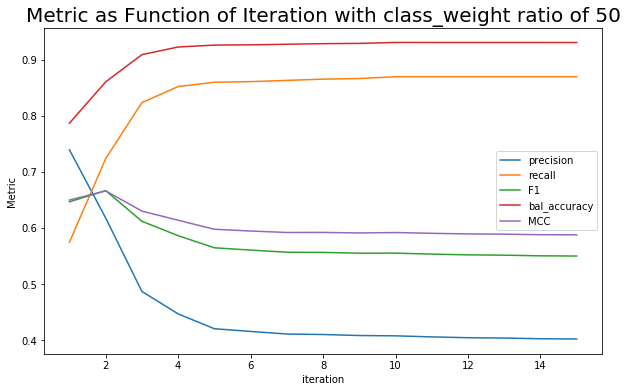

In [49]:
#plot performance
x_vals = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
precs_plt = [recursive_frames_adj[i-1].mean().precision for i in x_vals]
recs_plt = [recursive_frames_adj[i-1].mean().recall for i in x_vals]
f1s_plt = [recursive_frames_adj[i-1].mean().f1 for i in x_vals]
bal_acc_plt = [recursive_frames_adj[i-1].mean().bal_acc for i in x_vals]
matt_coeff_plt = [recursive_frames_adj[i-1].mean().matt_coef for i in x_vals]

plt.figure(figsize = (10,6))
plt.plot(x_vals, precs_plt,label= 'precision')
plt.plot(x_vals, recs_plt, label = 'recall')
plt.plot(x_vals, f1s_plt, label = 'F1')
plt.plot(x_vals, bal_acc_plt, label = 'bal_accuracy')
plt.plot(x_vals, matt_coeff_plt, label = 'MCC')
plt.xlabel('iteration')
plt.ylabel('Metric')
plt.title('Metric as Function of Iteration with class_weight ratio of '+str(weight_1), fontsize = 20)
plt.legend()
    
    
    

## Obtain Feature Importances

Feature ranking:
1. feature 4 (0.280051)
2. feature 2 (0.233492)
3. feature 6 (0.204176)
4. feature 3 (0.106397)
5. feature 5 (0.073073)
6. feature 1 (0.062187)
7. feature 0 (0.035476)
8. feature 7 (0.002124)
9. feature 9 (0.001665)
10. feature 8 (0.001359)


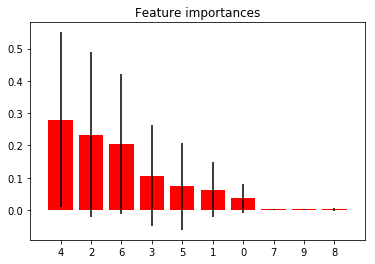

In [50]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_scaled.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_scaled.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), indices)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

## Show Table of RF and Recurrent RF Result for GD1 (One Iteration)

In [54]:
recursive_frames[0]

,true_positives,false_positives,true_negatives,false_negatives,precision,recall,f1,f1_prec_10,f1_prec_5,f1_rec_5,f1_rec_10
0,533,129,133500,379,0.805136,0.58443,0.677255,0.802137,0.793609,0.590657,0.58602


In [55]:
recursive_frames[14]

,true_positives,false_positives,true_negatives,false_negatives,precision,recall,f1,f1_prec_10,f1_prec_5,f1_rec_5,f1_rec_10
0,785,942,132545,125,0.454545,0.862637,0.595374,0.456685,0.462969,0.833844,0.855037


## Visualize GD1

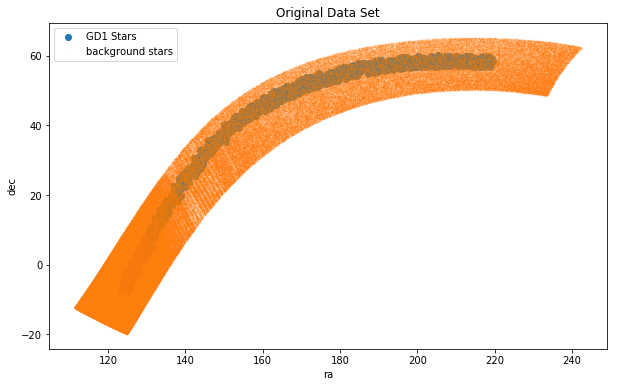

In [51]:
plt.figure(figsize=(10,6))
plt.scatter(dataset_gd1['ra'],dataset_gd1['dec'], label = 'GD1 Stars')
plt.scatter(dataset_nongd['ra'], dataset_nongd['dec'], label = 'background stars', s = 0.1, alpha = 0.2)
plt.title('Original Data Set')
plt.xlabel("ra")
plt.ylabel("dec")
plt.legend()

## Visualize True Positives and False Positives

Text(0.5, 1.0, 'Original Training vs. Added Stars')

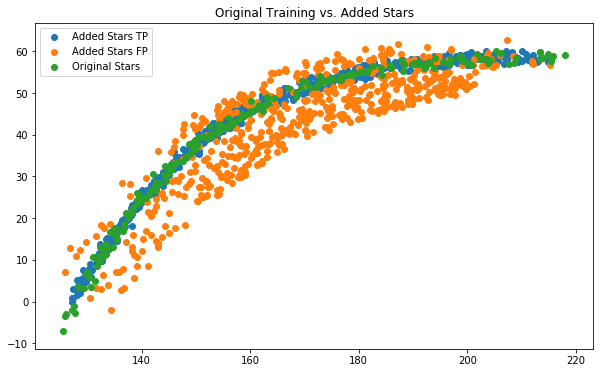

In [81]:
#X_added = X_correct_cum.append(X2_incorrect_cum, ignore_index = False, sort = False)
plt.figure(figsize=(10,6))
plt.scatter(X_correct_cum['ra'], X_correct_cum['dec'], label = 'Added Stars TP')
plt.scatter(X2_incorrect_cum['ra'], X2_incorrect_cum['dec'], label = 'Added Stars FP')
plt.scatter(stream_train_gd1['ra'], stream_train_gd1['dec'], label = 'Original Stars')
plt.legend()
plt.title('Original Training vs. Added Stars')